## K-Means Clustering for Image Classification

In [1]:
import sys
import sklearn
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mnist is a dataset of 60,000 28 x 28 pixel images of digits from 0 to 9, along with a test set of 10,000 images

In [2]:
# Importing the dataset from keras
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
# Checking the ‘type’
print(type(x_train))
print(type(x_test))
print(type(y_train))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


All of them are numpy arrays.

In [4]:
# Checking the shape
print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))
print('Testing Data: {}'.format(x_test.shape))
print('Testing Labels: {}'.format(y_test.shape))

Training Data: (60000, 28, 28)
Training Labels: (60000,)
Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


/Users/oorvasisooprayen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


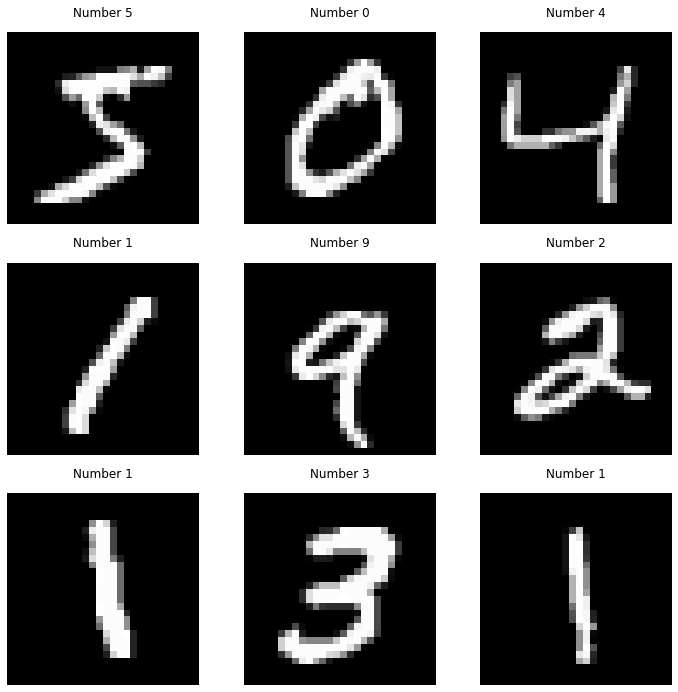

In [5]:
fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))

fig.show()

### Preprocessing the Data

In [6]:
# convert each image to 1 dimensional array

X = x_train.reshape(len(x_train),-1)
Y = y_train

# normalize the data to 0 - 1

X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


In [7]:
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(y_test))
print(n_digits)

# Initialize KMeans model

kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Fit the model to the training data

kmeans.fit(X)

10


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [8]:
kmeans.labels_

array([5, 8, 7, ..., 5, 2, 5], dtype=int32)

In [9]:
def infer_cluster_labels(kmeans, actual_labels):
    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))

    return inferred_labels

In [10]:
def infer_data_labels(X_labels, cluster_labels):
  # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)

    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
            
    return predicted_labels

# test the infer_cluster_labels() and infer_data_labels() functions

cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(Y[:20])

[8 0 4 1 7 2 1 8 1 7 3 1 3 6 1 7 2 8 6 7]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


Define a function that calculates metrics for the model

In [11]:
from sklearn import metrics

def calculate_metrics(estimator, data, labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

In [12]:
clusters = [10, 16, 36, 64, 144, 256]

# test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X)
    
    # print cluster metrics
    calculate_metrics(estimator, X, Y)
    
    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    
    # calculate and print accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))

Number of Clusters: 10
Inertia: 2378356.4114332804
Homogeneity: 0.46177144868832004
Accuracy: 0.5423833333333333

Number of Clusters: 16
Inertia: 2275008.266523639
Homogeneity: 0.5299093288238497
Accuracy: 0.6490166666666667

Number of Clusters: 36
Inertia: 1956481.0153198887
Homogeneity: 0.6932771450733026
Accuracy: 0.778

Number of Clusters: 64
Inertia: 1809662.1330931836
Homogeneity: 0.735593869912419
Accuracy: 0.8005

Number of Clusters: 144
Inertia: 1635431.46244145
Homogeneity: 0.8007357064517581
Accuracy: 0.8603666666666666

Number of Clusters: 256
Inertia: 1516338.574893777
Homogeneity: 0.8410853259870867
Accuracy: 0.8923



In [13]:
# test kmeans algorithm on testing dataset
# convert each image to 1 dimensional array
X_test = x_test.reshape(len(x_test),-1)

# normalize the data to 0 - 1
X_test = X_test.astype(float) / 255.

# initialize and fit KMeans algorithm on training data
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(X)
cluster_labels = infer_cluster_labels(kmeans, Y)

# predict labels for testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(kmeans.predict(X_test), cluster_labels)
    
# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_labels)))

Accuracy: 0.8978



In [14]:
X.shape

(60000, 784)

/Users/oorvasisooprayen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


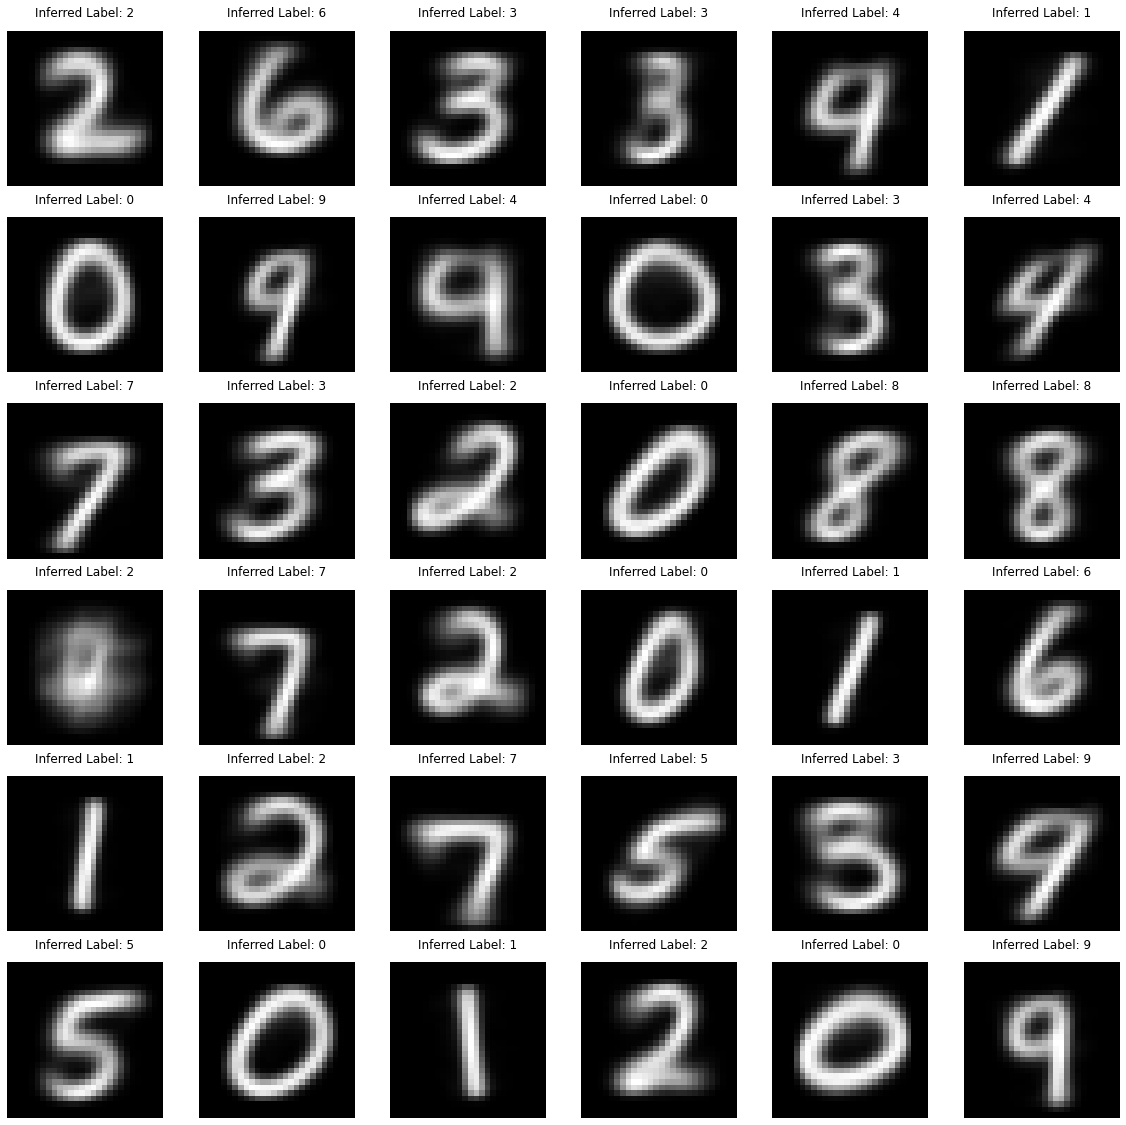

In [15]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()

In [16]:
# RGB image is converted to Monochrome image
from skimage import color
from skimage import io
image2 = color.rgb2gray(io.imread("num.jpg"))

In [17]:
image3 = color.rgb2gray(io.imread("num4.jpg"))

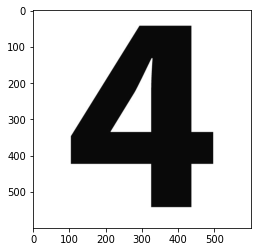

In [18]:
plt.imshow(image3)

In [19]:
type(fit_and_resized_image)

NameError: name 'fit_and_resized_image' is not defined

In [20]:
image3.shape

(600, 600)

In [21]:
from skimage.transform import resize
size = (28, 28)
fit_and_resized_image = resize(image3,size,anti_aliasing=True)

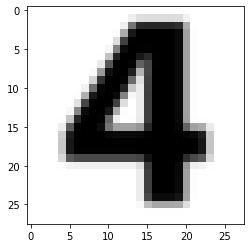

In [22]:
plt.imshow(fit_and_resized_image)

In [23]:
fit_and_resized_image.shape

(28, 28)

In [24]:
fit_and_resized_image = fit_and_resized_image.reshape(1, 28*28)
fit_and_resized_image.shape

(1, 784)

In [26]:
kmeans.predict(fit_and_resized_image)

array([18], dtype=int32)

Create function to generate the message

In [84]:
from email import encoders
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import base64
import os.path
import pickle
from apiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
def create_message(sender, to, subject, message_text):
    message = MIMEText(message_text)
    message['to'] = 'minie_oorvasi@hotmail.com'
    message['from'] = 'minie_oorvasi@hotmail.com'
    message['subject'] = 'kmeans'
    return {'raw': base64.urlsafe_b64encode(message.as_string().encode()).decode()}

Create the function to send the message

In [85]:
def send_message(service, user_id, message):
    try:
        message = (service.users().messages().send(userId=user_id, body=message).execute())
        print('Message Id: {}'.format(message['id']))
        return message
    except:
        print ('An error occurred')

Create a function to automate the notification system

In [86]:
from __future__ import print_function

# If modifying these scopes, delete the file token.pickle.
SCOPES = ['https://www.googleapis.com/auth']

def main():

    creds = None
    message = create_message(sender, to, subject, notification)
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('people', 'v1', credentials=creds)
    send_message(service, sender, message)

In [87]:
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
#Loading the dataset and only using the numerical variables
#mpg = sns.load_dataset('mpg').drop(['origin', 'name'], axis = 1)
#linear_model = LinearRegression()
try:
    #Training the model
    #linear_model.fit(mpg.drop('mpg', axis =1), mpg['mpg'])
    notification('minie_oorvasi@hotmail.com', 'minie_oorvasi@hotmail.com', 'Notification - Success Training', 'The model has finish')
except:
    notification('minie_oorvasi@hotmail.com', 'minie_oorvasi@hotmail.com', 'Notification - Failed Training', 'The model encountered error')

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=278055040496-t7ji91mp5sgs6987el89ro81ah114o9h.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A60433%2F&scope=https%3A%2F%2Fmail.google.com%2F&state=NrkHkiy39dwUjWHj4h0SfcpTYBe6aE&access_type=offline
Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=278055040496-t7ji91mp5sgs6987el89ro81ah114o9h.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A60520%2F&scope=https%3A%2F%2Fmail.google.com%2F&state=0UUxvkjCIFLbpr8sevvN0ugwVK1xIw&access_type=offline


KeyboardInterrupt: 